# CUSTOMHyS for Designing Microchannel Heat Sinks

## 0. Packages' installation and loading

In [1]:
%pwd

'C:\\Users\\memo_\\PycharmProjects\\Microchannels'

Instalamos el paquete de Customhys directo del repositorio

In [2]:
!pip3 install install customhys==1.0.1.dev1

You should consider upgrading via the 'C:\Users\memo_\PycharmProjects\Microchannels\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Cargamos los paquetes que vamos a utilizar

In [3]:
import numpy as np
from microchannels import Microchannel
from materials import Copper, Air, Titanium, Aluminium, Graphite, Silicon, AlNF, TiONF, Water
from customhys import metaheuristic as mh

## 1. Microchannel Heat Sink model preparation
En esta parte, preparamos el modelo para utilizarlo y evaluar una configuración de parámetros de diseño en la función objetivo, que en este caso será al generación de entropía.

In [208]:
class MicrochannelDesign():
    def __init__(self):
        self.model = Microchannel(base=Silicon(), coolant=Water())
        #self.max_search_range = np.array([self.model.W_d/10, self.model.W_d/10, 0.005])
        #self.min_search_range = np.array([1e-24, 1e-12, 1e-8])
        # self.max_search_range = np.array([2.72e-4, 8.5e-4])
        # self.min_search_range = np.array([4.08e-12, 8.5e-12])
        self.max_search_range = np.array([1.0, 1000, 1e-3])
        self.min_search_range = np.array([1e-3, 2, 1e-6])
        #self.func_name = 'Microchannel entropy generation model'

    def get_func_val(self, variables):

        alpha = variables[0]
        beta = variables[1]

        self.model.w_c = alpha * 1.7e-3 / 2
        self.model.w_w = self.model.w_c / beta
        self.model.G_d = variables[2]
        #print(self.model.G_d)
        #print(self.model.alpha)
        #print(self.model.beta)
        return self.model.sgen

    def get_formatted_problem(self, is_constrained=True):
        return dict(function=self.get_func_val,
                    boundaries=(self.min_search_range, self.max_search_range),
                    is_constrained=True)

fun = MicrochannelDesign()

## 2. Metaheuristic preparation

In [209]:
# Primero cargamos la colección de operadores
with open('./source/collections/' + 'default.txt', 'r') as operators_file:
    heuristic_space = [eval(line.rstrip('\n')) for line in operators_file]

Esta es la parte en donde, utilizando los operadores, ensamblamos la metaheurística a usar:

In [210]:
# Metaheuristic 1: Random Search
# heur = [('random_search', {'scale': 0.01, 'distribution': 'uniform'}, 'greedy')]

# Metaheuristic 2: Particle Swarm & Genetic Linear Crossover with Random Pairing and Metropolis Selection
heur = [('swarm_dynamic', {'factor': 0.7, 'self_conf': 2.54, 'swarm_conf': 2.56, 'version': 'inertial', 'distribution': 'uniform'}, 'all'),
        ('genetic_crossover', {'pairing': 'random', 'crossover': 'linear_0.5_0.5', 'mating_pool_factor': 0.4}, 'metropolis')]

#heur = [('genetic_crossover',
#  {'pairing': 'rank', 'crossover': 'linear_0.5_0.5', 'mating_pool_factor': 0.4},
 # 'all'),
  #      ('swarm_dynamic',
  #{'factor': 0.7, 'self_conf': 2.54, 'swarm_conf': 2.56, 'version': 'inertial', 'distribution': 'gaussian'},
  #'probabilistic'),
   #     ('genetic_crossover',
  #{'pairing': 'random', 'crossover': 'blend', 'mating_pool_factor': 0.4},
  #'probabilistic')]


#Metaheuristic 3: Genetic Algorithm
#heur = [('genetic_crossover', {'pairing': 'tournament_2_100', 'crossover': 'single', 'mating_pool_factor': 0.4}, 'all'), ('genetic_mutation', {'scale': 1.0, 'elite_rate': 0.1, 'mutation_rate': 0.25, 'distribution': 'uniform'}, 'all')]

Aquí terminamos de definirla empleando CUSTOMHyS


In [211]:
met = mh.Metaheuristic(fun.get_formatted_problem(is_constrained=True), heur , num_iterations=100)

## 3. Run designing process

In [212]:
# Aquí corremos la metaheurística seleccionada
met.verbose = True  # Se puede comentar para que no muestre todo el log

met.run()


Search operators to employ:
swarm_dynamic(factor=0.7,self_conf=2.54,swarm_conf=2.56,version='inertial',distribution='uniform') with all
genetic_crossover(pairing='random',crossover='linear_0.5_0.5',mating_pool_factor=0.4) with metropolis
--------------------------------------------------
1
pop. radius: 1.5477787378120638
x_best = [2.12253546e-01 2.00000000e+00 1.00000000e-06], f_best = 2.14830108446973e-06
2
pop. radius: 0.3903743420033089
x_best = [2.33546744e-01 2.00000000e+00 1.00000000e-06], f_best = 2.1465985024201705e-06
3
pop. radius: 0.10801269206697428
x_best = [2.36983797e-01 2.00000000e+00 1.00000000e-06], f_best = 2.1464008252920953e-06
4
pop. radius: 0.07458123487752577
x_best = [2.28761405e-01 2.00000000e+00 1.00000000e-06], f_best = 2.1462924828266463e-06
5
pop. radius: 0.058903274039326325
x_best = [2.2889704e-01 2.0000000e+00 1.0000000e-06], f_best = 2.146226710503227e-06
6
pop. radius: 0.050544327475428696
x_best = [2.2889704e-01 2.0000000e+00 1.0000000e-06], f_best 

## 4. Results' visualization

En esta primera gráfica, solo veremos la evolución de la función objetivo (generación de entropía)

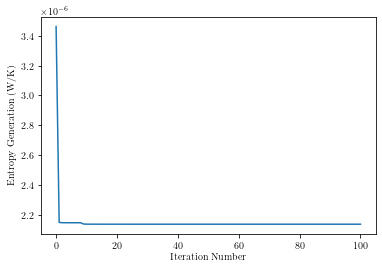

In [213]:
import matplotlib.pyplot as plt

plt.plot(met.historical["fitness"])
plt.ylabel(r'Entropy Generation (W/K)')
plt.xlabel(r'Iteration Number')
plt.show()

In [214]:
sol, fitness = met.get_solution()

print(f"alpha = {sol[0]:.2g}, beta = {sol[1]:.2g}, G = {sol[2]:.2g}, S_gen = {fitness:.6e} W/K")

alpha = 0.23, beta = 4.6, G = 1e-06, S_gen = 2.136433e-06 W/K


In [186]:
fun.model.w_w

4.079367147255925e-05

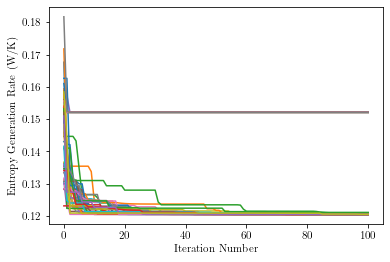

In [313]:
for i in range(1,50):
    met = mh.Metaheuristic(fun.get_formatted_problem(is_constrained=True), heur , num_iterations=100)
    met.run()
    plt.plot(met.historical["fitness"])
plt.ylabel(r'Entropy Generation Rate (W/K)')
plt.xlabel(r'Iteration Number')
plt.gcf()
plt.savefig('resultsMH.jpg')
plt.show()



In [46]:
# from source import experiment as ex
# expe = ex.Experiment()
# expe.hh_configr
# expe.exp_config
# expe.prob_config
# expe.run()
from customhys import hyperheuristic as hh
prob = fun.get_formatted_problem(is_constrained=True)
hyp = None

for i in range(1,2):
    del hyp
    hyp = hh.Hyperheuristic(heuristic_space=heuristic_space, problem=prob, file_label="MC_results_Copper_Air_%d"%i, parameters=
                            dict(cardinality=3,                # Max. numb. of SOs in MHs, lvl:1
                              num_iterations=100,           # Iterations a MH performs, lvl:1
                              num_agents=30,                # Agents in population,     lvl:1
                              num_replicas=30,              # Replicas per each MH,     lvl:2
                              num_steps=100,                # Trials per HH step,       lvl:2
                              stagnation_percentage=0.3,    # Stagnation percentage,    lvl:2
                              max_temperature=200,          # Initial temperature (SA), lvl:2
                              cooling_rate=0.1)
    )
    sol, perf, e_sol = hyp.run()
    print( sol, perf, e_sol, "\n\n")


MC_results_Copper_Air_1 :: Step: 0, Perf: 0.17361096240645799, e-Sol: [195]
MC_results_Copper_Air_1 :: Step: 3, Perf: 0.17211986450293926, e-Sol: [202]
MC_results_Copper_Air_1 :: Step: 33, Perf: 0.17211985470670643, e-Sol: [136 186  85]
MC_results_Copper_Air_1 :: Step: 52, Perf: 0.1721198547066086, e-Sol: [148]
MC_results_Copper_Air_1 :: Step: 83, Perf: 0.17211985470659716, e-Sol: [145]
[['random_flight' {'scale': 1.0, 'distribution': 'gaussian'} 'all']] 0.17211985470659716 [145] 




In [11]:
class MicrochannelDesign():
    def __init__(self):
        self.model = Microchannel(base=Graphite(), coolant=Water())
        #self.max_search_range = np.array([self.model.W_d/10, self.model.W_d/10, 0.005])
        #self.min_search_range = np.array([1e-24, 1e-12, 1e-8])
        self.max_search_range = np.array([2.65e-5, 20.4e-5, 0.009])
        self.min_search_range = np.array([4.53e-5, 13.6e-5, 0.005])
        self.func_name = 'Microchannel entropy generation model'

    def get_func_val(self, variables):
        self.model.w_w = variables[0]
        self.model.w_c = variables[1]
        self.model.G_d = variables[2]
        #print(self.model.G_d)
        #print(self.model.alpha)
        #print(self.model.beta)
        return self.model.sgen

    def get_formatted_problem(self, is_constrained=True):
        return dict(function=self.get_func_val,
                    boundaries=(self.min_search_range, self.max_search_range),
                    is_constrained=is_constrained)

fun = MicrochannelDesign()

In [12]:
from customhys  import hyperheuristic as hh
prob = fun.get_formatted_problem(is_constrained=True)
hyp = None
for i in range(26,31):
    del hyp
    hyp = hh.Hyperheuristic(heuristic_space=heuristic_space, problem=prob, file_label="MC_results2_Graphite_Wat_Ag_50_Stag_10_%d"%i, parameters=
                            dict(cardinality=3,                # Max. numb. of SOs in MHs, lvl:1
                              num_iterations=100,           # Iterations a MH performs, lvl:1
                              num_agents=50,                # Agents in population,     lvl:1
                              num_replicas=30,              # Replicas per each MH,     lvl:2
                              num_steps=100,                # Trials per HH step,       lvl:2
                              stagnation_percentage=0.1,    # Stagnation percentage,    lvl:2
                              max_temperature=200,          # Initial temperature (SA), lvl:2
                              cooling_rate=0.1)
    )
    sol, perf, e_sol = hyp.run()
    print( sol, perf, e_sol, "\n\n")

MC_results2_Graphite_Wat_Ag_50_Stag_10_26 :: Step: 0, Perf: 108.52248126279315, e-Sol: [110]
MC_results2_Graphite_Wat_Ag_50_Stag_10_26 :: Step: 1, Perf: 107.49252218594403, e-Sol: [105]
MC_results2_Graphite_Wat_Ag_50_Stag_10_26 :: Step: 2, Perf: 94.3618260800781, e-Sol: [190 105]
[['swarm_dynamic'
  {'factor': 0.7, 'self_conf': 2.54, 'swarm_conf': 2.56, 'version': 'inertial', 'distribution': 'levy'}
  'greedy']
 ['genetic_crossover'
  {'pairing': 'rank', 'crossover': 'linear_0.5_0.5', 'mating_pool_factor': 0.4}
  'all']] 94.3618260800781 [190 105] 


MC_results2_Graphite_Wat_Ag_50_Stag_10_27 :: Step: 0, Perf: 94.91237108307433, e-Sol: [195]
MC_results2_Graphite_Wat_Ag_50_Stag_10_27 :: Step: 1, Perf: 94.36182203379083, e-Sol: [139 195]
[['random_flight' {'scale': 1.0, 'distribution': 'levy', 'beta': 1.5}
  'metropolis']
 ['swarm_dynamic'
  {'factor': 1.0, 'self_conf': 2.54, 'swarm_conf': 2.56, 'version': 'constriction', 'distribution': 'uniform'}
  'metropolis']] 94.36182203379083 [139 

In [ ]:
parameters=dict(
        cardinality=3,  # Max. numb. of SOs in MHs, lvl:1
        num_iterations=500,  # Iterations a MH performs, lvl:1
        num_agents=300,  # Agents in population,     lvl:1
        num_replicas=30,  # Replicas per each MH,     lvl:2
        num_steps=100,  # Trials per HH step,       lvl:2
        stagnation_percentage=0.5,  # Stagnation percentage,    lvl:2
        max_temperature=200,  # Initial temperature (SA), lvl:2
        cooling_rate=0.05,  # Cooling rate (SA),        lvl:2)
        compute_replicas_in_parallel=False,
        compute_agents_in_parallel=True)

In [6]:
import json
import glob
import os

list_of_files = glob.glob('/path/to/folder/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
# Opening JSON file
with open('data.json') as json_file:
    data = json.load(json_file)

    # for reading nested data [0] represents
    # the index value of the list
    print(data['people1'][0])

    # for printing the key-value pair of
    # nested dictionary for loop can be used
    print("\nPrinting nested dictionary as a key-value pair\n")
    for i in data['people1']:
        print("Name:", i['name'])
        print("Website:", i['website'])
        print("From:", i['from'])
        print()

ValueError: max() arg is an empty sequence

In [33]:
import glob
import os
import json
import numpy as np
import matplotlib.pyplot as plt

CA_def=['data_files/raw/' + filename for filename \
                  in os.listdir('data_files/raw/') if filename.startswith("MC_results_Copper_Air_Stag")]
vec=np.empty([30])
file_type = r'\*json'
i=0
for folder in CA_def:
    print(folder)
    list_of_files = glob.glob(folder + file_type)
    print(list_of_files)
    #latest_file = (list_of_files, key=os.path.getmtime)
    print(latest_file)
    with open(latest_file) as json_file:
        data = json.load(json_file)
        vec[i]=data['performance']
    i=i+1

# Creating plot
plt.boxplot(vec)

# show plot
plt.show()
print(vec)

data_files/raw/MC_results_Copper_Air_Stag_10
[]
[]


TypeError: expected str, bytes or os.PathLike object, not list

In [2]:
import glob
import os
import json
import numpy as np
import matplotlib.pyplot as plt

folderO=['data_files/raw/' + filename for filename \
                  in os.listdir('data_files/raw/') if filename.startswith("MC_results1_")]
perf=np.empty([20,30])
comb=np.empty([20,30],dtype=object)
file_type = r'\*json'
row=0
for folder in folderO:
    folderI=[folder + '/' + filename for filename \
                  in os.listdir(folder) ]
    column=0
    print(folder)
    for folder2 in folderI:
        #print(folder2)
        list_of_files = glob.glob(folder2 + file_type)
        #print(list_of_files)
        latest_file = max(list_of_files, key=os.path.getmtime)
        #print(latest_file)
        with open(latest_file) as json_file:
            data = json.load(json_file)
            perf[row,column]=data['performance']
            comb[row,column]=data['encoded_solution']
        column=column+1
    row=row+1

# Creating plot
#plt.boxplot(vec)

# show plot
#plt.show()
print(perf)
print(comb)

data_files/raw/MC_results1_Al_Water
data_files/raw/MC_results1_Al_Water_Ag_50
data_files/raw/MC_results1_Al_Water_Card_2
data_files/raw/MC_results1_Al_Water_It_50
data_files/raw/MC_results1_Al_Water_Stag_10
data_files/raw/MC_results1_Copper_Water
data_files/raw/MC_results1_Copper_Water_Ag_50
data_files/raw/MC_results1_Copper_Water_Card_2
data_files/raw/MC_results1_Copper_Water_It_50
data_files/raw/MC_results1_Copper_Water_Stag_10
data_files/raw/MC_results1_Graphite_Water
data_files/raw/MC_results1_Graphite_Water_Ag_50
data_files/raw/MC_results1_Graphite_Water_Card_2
data_files/raw/MC_results1_Graphite_Water_It_50
data_files/raw/MC_results1_Graphite_Water_Stag_10
data_files/raw/MC_results1_Silicium_Water
data_files/raw/MC_results1_Silicium_Water_Ag_50
data_files/raw/MC_results1_Silicium_Water_Card_2
data_files/raw/MC_results1_Silicium_Water_It_50
data_files/raw/MC_results1_Silicium_Water_Stag_10
[[1.02609070e-06 1.02620590e-06 1.02890621e-06 1.02657297e-06
  1.02643439e-06 1.02843061e-0

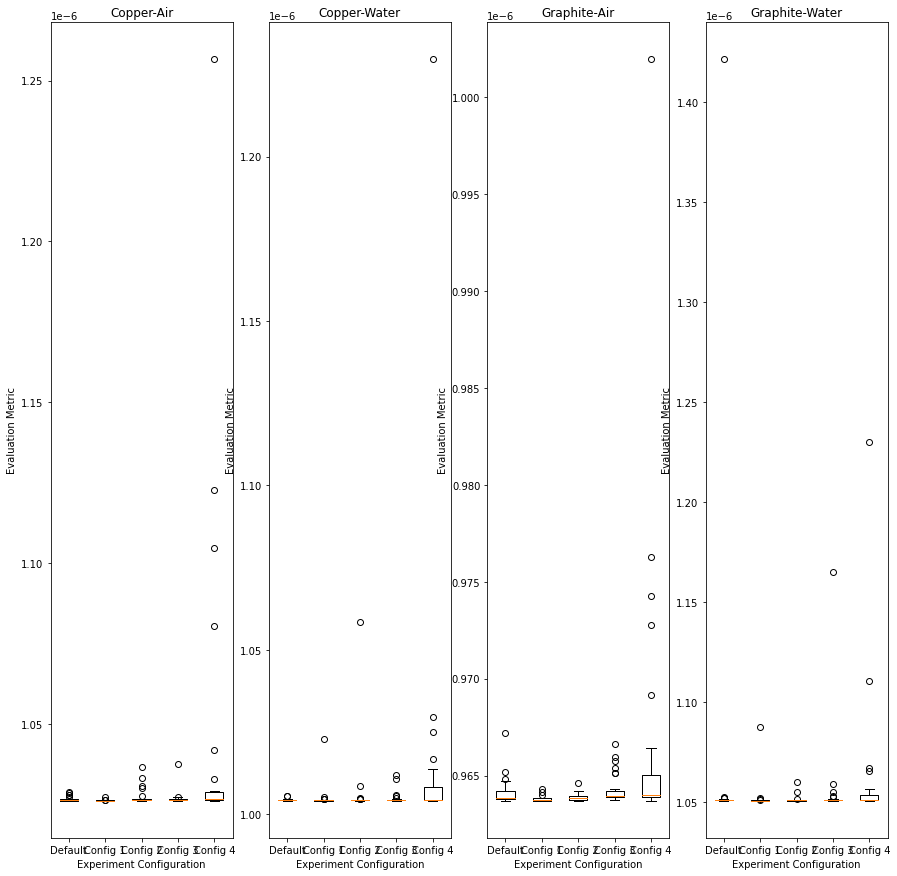

In [3]:
C_A=[perf[0,:],perf[1,:],perf[2,:],perf[3,:],perf[4,:]]
C_W=[perf[5,:],perf[6,:],perf[7,:],perf[8,:],perf[9,:]]
G_A=[perf[10,:],perf[11,:],perf[12,:],perf[13,:],perf[14,:]]
G_W=[perf[15,:],perf[16,:],perf[17,:],perf[18,:],perf[19,:]]

#labels = ['Default', '50 Agents', 'Cardinality 2', '50 Iterations', '10 Stagnation']
labels = ['Default', 'Config 1', 'Config 2', 'Config 3', 'Config 4']

fig = plt.figure(figsize =(15, 15))
ax1 =fig.add_subplot(1,4,1)
plt.boxplot(C_A)
plt.title("Copper-Air")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax2 =fig.add_subplot(1,4,2)
plt.boxplot(C_W)
plt.title("Copper-Water")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax3 =fig.add_subplot(1,4,3)
plt.boxplot(G_A)
plt.title("Graphite-Air")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax4 =fig.add_subplot(1,4,4)
plt.boxplot(G_W)
plt.title("Graphite-Water")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
plt.gcf()
plt.savefig('resultsHH.jpg')
plt.show()



In [4]:
dat = np.array([C_A, C_W, G_A, G_W])
np.save('data_memo',dat)

In [5]:
dat

array([[[1.02609070e-06, 1.02620590e-06, 1.02890621e-06, 1.02657297e-06,
         1.02643439e-06, 1.02843061e-06, 1.02655263e-06, 1.02616935e-06,
         1.02732702e-06, 1.02628121e-06, 1.02616727e-06, 1.02604781e-06,
         1.02625158e-06, 1.02607516e-06, 1.02618394e-06, 1.02604520e-06,
         1.02607020e-06, 1.02793779e-06, 1.02641294e-06, 1.02605601e-06,
         1.02614253e-06, 1.02611063e-06, 1.02611899e-06, 1.02784663e-06,
         1.02628761e-06, 1.02622854e-06, 1.02611831e-06, 1.02614143e-06,
         1.02654083e-06, 1.02639124e-06],
        [1.02606082e-06, 1.02613495e-06, 1.02604928e-06, 1.02608645e-06,
         1.02713755e-06, 1.02610177e-06, 1.02608432e-06, 1.02637339e-06,
         1.02635610e-06, 1.02604521e-06, 1.02605015e-06, 1.02608752e-06,
         1.02605046e-06, 1.02610895e-06, 1.02623873e-06, 1.02623770e-06,
         1.02604906e-06, 1.02607472e-06, 1.02605011e-06, 1.02616047e-06,
         1.02604520e-06, 1.02625800e-06, 1.02612959e-06, 1.02631017e-06,
         

Text(0.5, 0, 'Experiment Configuration')

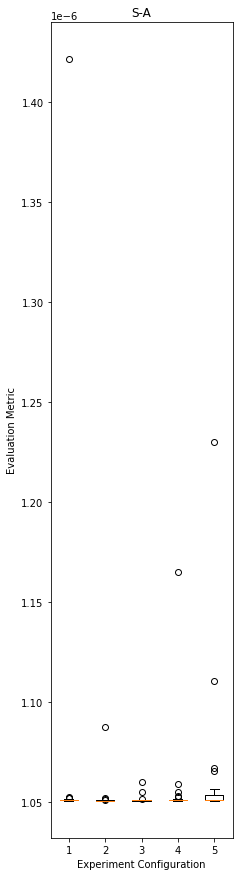

In [11]:
fig = plt.figure(figsize =(15, 15))
ax1 =fig.add_subplot(1,4,1)
plt.boxplot(S_W)
plt.title("S-A")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")

In [6]:
ind_best_perf = np.argmin(perf, axis=1)
best_mhs = [comb[row, col] for row, col in enumerate(ind_best_perf)]
best_mhs

[[92, 115, 28],
 [26, 115, 2],
 [195, 184],
 [198, 196],
 [14, 90, 154],
 [22, 200, 119],
 [18, 126, 110],
 [93, 26],
 [110, 12, 195],
 [6, 90],
 [26, 90],
 [34, 111, 26],
 [91, 26],
 [14, 92, 194],
 [22, 196, 137],
 [199, 57, 196],
 [170, 28, 117],
 [26, 90],
 [64, 198, 196],
 [196, 0, 186]]

In [7]:
best_mhs = [perf[row, col] for row, col in enumerate(ind_best_perf)]
best_mhs

[1.0260452033239058e-06,
 1.0260452033239056e-06,
 1.026052764112821e-06,
 1.0260651106846765e-06,
 1.0260452538282889e-06,
 1.0041345326868018e-06,
 1.0041345245695694e-06,
 1.0041779375866535e-06,
 1.0041905631089816e-06,
 1.0041359548404956e-06,
 9.637023945145323e-07,
 9.637021710021423e-07,
 9.637046469215461e-07,
 9.637260396339575e-07,
 9.63713491534606e-07,
 1.050565713044866e-06,
 1.0505441696477707e-06,
 1.0505453628823821e-06,
 1.0505674767519043e-06,
 1.0505815445093405e-06]

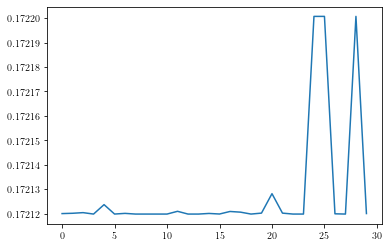

In [8]:
np.set_printoptions(precision=55)
plt.plot(perf[4,:])
plt.show()

In [36]:
folderO=['data_files/raw/' + filename for filename \
                  in os.listdir('data_files/raw/') if filename.startswith("MC_results3_")]
perf2=np.empty([4,30])
comb2=np.empty([4,30],dtype=object)
file_type = r'\*json'
row=0
for folder in folderO:
    folderI=[folder + '/' + filename for filename \
                  in os.listdir(folder) ]
    column=0
    print(folder)
    for folder2 in folderI:
        #print(folder2)
        list_of_files = glob.glob(folder2 + file_type)
        #print(list_of_files)
        latest_file = max(list_of_files, key=os.path.getmtime)
        #print(latest_file)
        with open(latest_file) as json_file:
            data = json.load(json_file)
            perf2[row,column]=data['performance']
            comb2[row,column]=data['encoded_solution']
        column=column+1
    row=row+1

# Creating plot
#plt.boxplot(vec)

# show plot
#plt.show()
print(perf2)
print(comb2)

data_files/raw/MC_results3_Aluminium_Water
data_files/raw/MC_results3_Aluminium_Water_Ag_50
data_files/raw/MC_results3_Aluminium_Water_Card_2
data_files/raw/MC_results3_Aluminium_Water_It_50
data_files/raw/MC_results3_Aluminium_Water_Stag_10


IndexError: index 4 is out of bounds for axis 0 with size 4

In [15]:
C_A=[perf[0,:],perf[1,:],perf[4,:],perf2[0,:]]
C_W=[perf[5,:],perf[6,:],perf[9,:],perf2[1,:]]
G_A=[perf[10,:],perf[11,:],perf[14,:],perf2[2,:]]
G_W=[perf[15,:],perf[16,:],perf[19,:],perf2[3,:]]

labels = ['Default', '50 Agents','10 Stagnation','AG-Stag']

fig = plt.figure(figsize =(15, 15))
ax1 =fig.add_subplot(2,2,1)
plt.boxplot(C_A)
plt.title("Copper-Air")
plt.ylabel("Performance")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4], labels)
ax2 =fig.add_subplot(2,2,2)
plt.boxplot(C_W)
plt.title("Copper-Water")
plt.ylabel("Performance")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4], labels)
ax3 =fig.add_subplot(2,2,3)
plt.boxplot(G_A)
plt.title("Graphite-Air")
plt.ylabel("Performance")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4], labels)
ax4 =fig.add_subplot(2,2,4)
plt.boxplot(G_W)
plt.title("Graphite-Water")
plt.ylabel("Performance")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4], labels)
plt.gcf()
plt.savefig('resultsHH2.jpg')
plt.show()


NameError: name 'perf2' is not defined

In [12]:
index=np.empty([1,20])
operators=np.empty([1,20])
for i in range(0,20):
    y=perf[i,:]
    x=np.argmin(y)
    index[0,i]=x
print(index)

[[15. 20. 19. 17.  5. 23. 25.  7.  6.  9.  4.  5. 20. 29.  7. 20.  6. 11.
   6. 18.]]


In [37]:
ind_best_perf = np.argmin(perf, axis=1)
best_mhs = [comb[row, col] for row, col in enumerate(ind_best_perf)]
best_mhs

[[92, 115, 28],
 [26, 115, 2],
 [195, 184],
 [198, 196],
 [14, 90, 154],
 [22, 200, 119],
 [18, 126, 110],
 [93, 26],
 [110, 12, 195],
 [6, 90],
 [26, 90],
 [34, 111, 26],
 [91, 26],
 [14, 92, 194],
 [22, 196, 137],
 [199, 57, 196],
 [170, 28, 117],
 [26, 90],
 [64, 198, 196],
 [196, 0, 186]]

In [1]:
ind_best_perf = np.argmin(perf, axis=1)
best_mhs = [perf[row, col] for row, col in enumerate(ind_best_perf)]
best_mhs

NameError: name 'np' is not defined

In [139]:
x=comb[19]
print(x)

[list([127]) list([174, 59]) list([201]) list([174]) list([134])
 list([10]) list([51]) list([200]) list([166]) list([174]) list([4])
 list([86]) list([119]) list([90, 176]) list([59]) list([124]) list([53])
 list([181]) list([18]) list([165, 24]) list([115]) list([145])
 list([204]) list([53]) list([104]) list([63]) list([47]) list([7])
 list([119]) list([104])]


In [15]:
ac_tot=[]

for y in range(0,len(comb)):
    arr_tot= np.array(comb[y], dtype=object)
    for i in range(0,len(arr_tot)):
        w_tot=np.array(arr_tot[i])
        for z in range(0,len(w_tot)):
            ac_tot.append(w_tot[z])

ac_tot=np.array(ac_tot)
print(ac_tot)


[ 89  70   5 ... 177  56 199]


In [16]:
sorted=np.sort(ac_tot);
num=[];
num2=[];
frec=[];
ind=[];
count=0;
while len(sorted)>0:
    num.append(str(sorted[0]))
    num2.append(sorted[0])
    cand=sorted[0]
    for i in range(0,len(sorted)):
        if cand == sorted[i]:
            count=count+1
            ind.append(i)
    frec.append(count)
    count=0
    sorted=np.delete(sorted,ind)
    ind=[];
print(num)
print(num2)
print(frec)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '32', '33', '34', '36', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '51', '52', '53', '54', '55', '56', '57', '58', '59', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '130', '131', '132', '133', '134', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '162', '164', '166', '167', '168', '16

In [17]:
fam=['random search','central force dynamic','differential mutation','firefly dynamic','genetic crossover','genetic mutation','gravitational search','random flight','local random walk','random sample','spiral dynamic','swarm dynamic']
frec2=[0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(0,len(num2)):
    if num2[i] == 0:
        frec2[0]= frec2[0] + frec[i]
    elif num2[i] >= 1 and num2[i] <= 4:
        frec2[1]= frec2[1] + frec[i]
    elif num2[i] >= 5 and num2[i] <= 28:
        frec2[2]= frec2[2] + frec[i]
    elif num2[i] >= 29 and num2[i] <= 40:
        frec2[3]= frec2[3] + frec[i]
    elif num2[i] >= 41 and num2[i] <= 120:
        frec2[4]= frec2[4] + frec[i]
    elif num2[i] >= 121 and num2[i] <= 132:
        frec2[5]= frec2[5] + frec[i]
    elif num2[i] >= 133 and num2[i] <= 136:
        frec2[6]= frec2[6] + frec[i]
    elif num2[i] >= 137 and num2[i] <= 148:
        frec2[7]= frec2[7] + frec[i]
    elif num2[i] >= 149 and num2[i] <= 160:
        frec2[8]= frec2[8] + frec[i]
    elif num2[i] >= 161 and num2[i] <= 164:
        frec2[9]= frec2[9] + frec[i]
    elif num2[i] >= 165 and num2[i] <= 176:
        frec2[0]= frec2[0] + frec[i]
    elif num2[i] >= 177 and num2[i] <= 180:
        frec2[10]= frec2[10] + frec[i]
    elif num2[i] >= 181 and num2[i] <= 204:
        frec2[11]= frec2[11] + frec[i]
print(frec2)
print(fam)


[38, 21, 163, 21, 416, 24, 14, 212, 56, 3, 10, 359]
['random search', 'central force dynamic', 'differential mutation', 'firefly dynamic', 'genetic crossover', 'genetic mutation', 'gravitational search', 'random flight', 'local random walk', 'random sample', 'spiral dynamic', 'swarm dynamic']


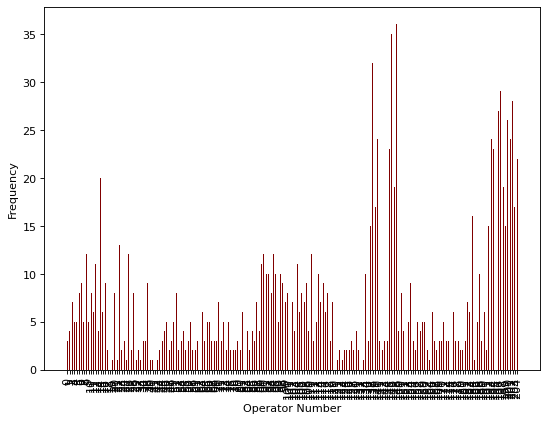

In [18]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(num, frec, color ='maroon',
        width = 0.4)
plt.xticks(range(len(num)), num, rotation='vertical')
plt.xlabel("Operator Number")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG1.jpg')
plt.show()

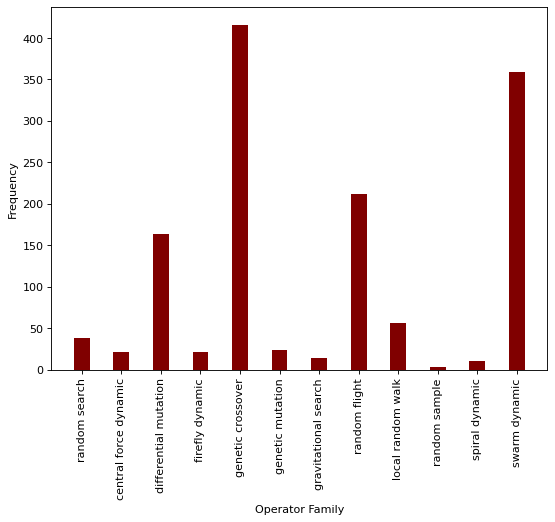

In [19]:
figure(figsize=(8, 6), dpi=80)
plt.bar(fam, frec2, color ='maroon',
        width = 0.4)
plt.xticks(range(len(fam)), fam, rotation='vertical')
plt.xlabel("Operator Family")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG2.jpg',bbox_inches='tight')
plt.show()

In [20]:
arr = np.array(best_mhs, dtype=object)
ac=[]

for i in range(0,len(arr)):
    w=np.array(arr[i])
    for z in range(0,len(w)):
        ac.append(w[z])

ac=np.array(ac)
print(ac)



[ 92 115  28  26 115   2 195 184 198 196  14  90 154  22 200 119  18 126
 110  93  26 110  12 195   6  90  26  90  34 111  26  91  26  14  92 194
  22 196 137 199  57 196 170  28 117  26  90  64 198 196 196   0 186]


In [21]:
sorted=np.sort(ac);
num=[];
num2=[];
frec=[];
ind=[];
count=0;
while len(sorted)>0:
    num.append(str(sorted[0]))
    num2.append(sorted[0])
    cand=sorted[0]
    for i in range(0,len(sorted)):
        if cand == sorted[i]:
            count=count+1
            ind.append(i)
    frec.append(count)
    count=0
    sorted=np.delete(sorted,ind)
    ind=[];
print(num)
print(num2)
print(frec)

['0', '2', '6', '12', '14', '18', '22', '26', '28', '34', '57', '64', '90', '91', '92', '93', '110', '111', '115', '117', '119', '126', '137', '154', '170', '184', '186', '194', '195', '196', '198', '199', '200']
[0, 2, 6, 12, 14, 18, 22, 26, 28, 34, 57, 64, 90, 91, 92, 93, 110, 111, 115, 117, 119, 126, 137, 154, 170, 184, 186, 194, 195, 196, 198, 199, 200]
[1, 1, 1, 1, 2, 1, 2, 6, 2, 1, 1, 1, 4, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 2, 1, 1]


In [22]:
fam=['random search','central force_dynamic','differential mutation','firefly dynamic','genetic crossover','genetic mutation','gravitational search','random flight','local random_walk','random sample','spiral dynamic','swarm dynamic']
frec2=[0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(0,len(num2)):
    if num2[i] == 0:
        frec2[0]= frec2[0] + frec[i]
    elif num2[i] >= 1 and num2[i] <= 4:
        frec2[1]= frec2[1] + frec[i]
    elif num2[i] >= 5 and num2[i] <= 28:
        frec2[2]= frec2[2] + frec[i]
    elif num2[i] >= 29 and num2[i] <= 40:
        frec2[3]= frec2[3] + frec[i]
    elif num2[i] >= 41 and num2[i] <= 120:
        frec2[4]= frec2[4] + frec[i]
    elif num2[i] >= 121 and num2[i] <= 132:
        frec2[5]= frec2[5] + frec[i]
    elif num2[i] >= 133 and num2[i] <= 136:
        frec2[6]= frec2[6] + frec[i]
    elif num2[i] >= 137 and num2[i] <= 148:
        frec2[7]= frec2[7] + frec[i]
    elif num2[i] >= 149 and num2[i] <= 160:
        frec2[8]= frec2[8] + frec[i]
    elif num2[i] >= 161 and num2[i] <= 164:
        frec2[9]= frec2[9] + frec[i]
    elif num2[i] >= 165 and num2[i] <= 176:
        frec2[0]= frec2[0] + frec[i]
    elif num2[i] >= 177 and num2[i] <= 180:
        frec2[10]= frec2[10] + frec[i]
    elif num2[i] >= 181 and num2[i] <= 204:
        frec2[11]= frec2[11] + frec[i]
print(frec2)
print(fam)


[2, 1, 15, 1, 17, 1, 0, 1, 1, 0, 0, 14]
['random search', 'central force_dynamic', 'differential mutation', 'firefly dynamic', 'genetic crossover', 'genetic mutation', 'gravitational search', 'random flight', 'local random_walk', 'random sample', 'spiral dynamic', 'swarm dynamic']


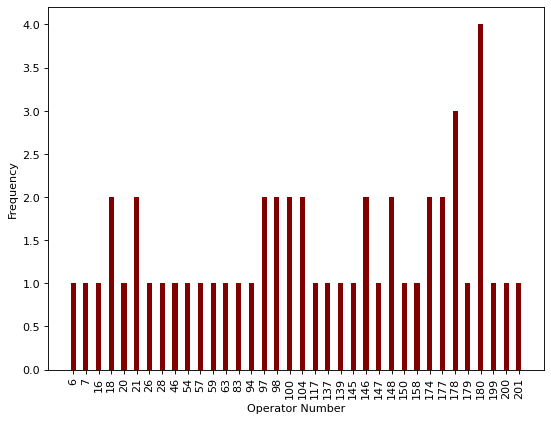

In [89]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(num, frec, color ='maroon',
        width = 0.4)
plt.xticks(range(len(num)), num, rotation='vertical')
plt.xlabel("Operator Number")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG3.jpg')
plt.show()

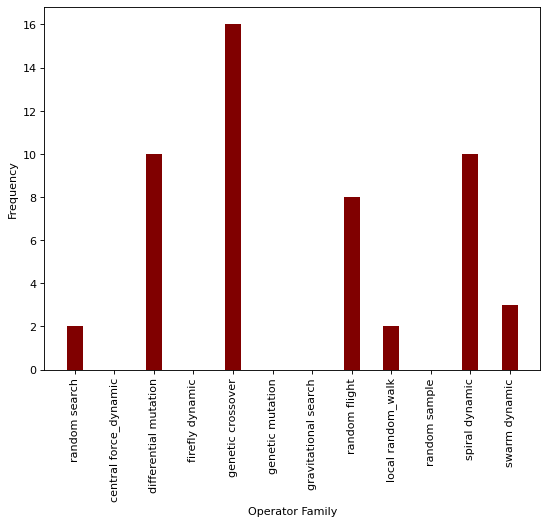

In [90]:
figure(figsize=(8, 6), dpi=80)
plt.bar(fam, frec2, color ='maroon',
        width = 0.4)
plt.xticks(range(len(fam)), fam, rotation='vertical')
plt.xlabel("Operator Family")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG4.jpg',bbox_inches='tight')
plt.show()

In [29]:
arr = np.array(best_mhs, dtype=object)
arr = np.transpose(arr)
arr.shape

(20,)

In [44]:

x=np.array(arr[0])
x[0]

157

In [63]:
ac=np.zeros(shape=(1, len(arr)))
print(ac)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [81]:
test=np.array([1,2,3])
test=np.delete(test,1)
h=len(test)
print(test)

[1 3]


In [100]:
heuristic_space

[('random_search', {'scale': 1.0, 'distribution': 'uniform'}, 'greedy'),
 ('central_force_dynamic',
  {'gravity': 0.001, 'alpha': 0.01, 'beta': 1.5, 'dt': 1.0},
  'all'),
 ('central_force_dynamic',
  {'gravity': 0.001, 'alpha': 0.01, 'beta': 1.5, 'dt': 1.0},
  'greedy'),
 ('central_force_dynamic',
  {'gravity': 0.001, 'alpha': 0.01, 'beta': 1.5, 'dt': 1.0},
  'metropolis'),
 ('central_force_dynamic',
  {'gravity': 0.001, 'alpha': 0.01, 'beta': 1.5, 'dt': 1.0},
  'probabilistic'),
 ('differential_mutation',
  {'expression': 'rand', 'num_rands': 1, 'factor': 1.0},
  'all'),
 ('differential_mutation',
  {'expression': 'rand', 'num_rands': 1, 'factor': 1.0},
  'greedy'),
 ('differential_mutation',
  {'expression': 'rand', 'num_rands': 1, 'factor': 1.0},
  'metropolis'),
 ('differential_mutation',
  {'expression': 'rand', 'num_rands': 1, 'factor': 1.0},
  'probabilistic'),
 ('differential_mutation',
  {'expression': 'best', 'num_rands': 1, 'factor': 1.0},
  'all'),
 ('differential_mutation'

In [80]:
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
index = [2, 3, 6]

new_a = np.delete(a, index)

print(new_a)

[1 2 5 6 8 9]


In [5]:
import glob
import os
import json
import numpy as np
import matplotlib.pyplot as plt

folderO=['data_files/raw/' + filename for filename \
                  in os.listdir('data_files/raw/') if filename.startswith("MC_results2_")]
perf4=np.empty([20,30])
comb4=np.empty([20,30],dtype=object)
file_type = r'\*json'
row=0
for folder in folderO:
    folderI=[folder + '/' + filename for filename \
                  in os.listdir(folder) ]
    column=0
    print(folder)
    for folder2 in folderI:
        #print(folder2)
        list_of_files = glob.glob(folder2 + file_type)
        #print(list_of_files)
        latest_file = max(list_of_files, key=os.path.getmtime)
        #print(latest_file)
        with open(latest_file) as json_file:
            data = json.load(json_file)
            perf4[row,column]=data['performance']
            comb4[row,column]=data['encoded_solution']
        column=column+1
    row=row+1

# Creating plot
#plt.boxplot(vec)

# show plot
#plt.show()
print(perf4)
print(comb4)

data_files/raw/MC_results2_Aluminium_Water
data_files/raw/MC_results2_Aluminium_Water_Ag_50
data_files/raw/MC_results2_Aluminium_Water_Card_2
data_files/raw/MC_results2_Aluminium_Water_It_50
data_files/raw/MC_results2_Aluminium_Water_Stag_10
data_files/raw/MC_results2_Copper_Water
data_files/raw/MC_results2_Copper_Water_Ag_50
data_files/raw/MC_results2_Copper_Water_Card_2
data_files/raw/MC_results2_Copper_Water_It_50
data_files/raw/MC_results2_Copper_Water_Stag_10
data_files/raw/MC_results2_Graphite_Water
data_files/raw/MC_results2_Graphite_Water_Ag_50
data_files/raw/MC_results2_Graphite_Water_Card_2
data_files/raw/MC_results2_Graphite_Water_It_50
data_files/raw/MC_results2_Graphite_Water_Stag_10
data_files/raw/MC_results2_Silicon_Water
data_files/raw/MC_results2_Silicon_Water_Ag_50
data_files/raw/MC_results2_Silicon_Water_Card_2
data_files/raw/MC_results2_Silicon_Water_It_50
data_files/raw/MC_results2_Silicon_Water_Stag_10
[[1.02604537e-06 1.02604899e-06 1.02605202e-06 1.02615700e-06


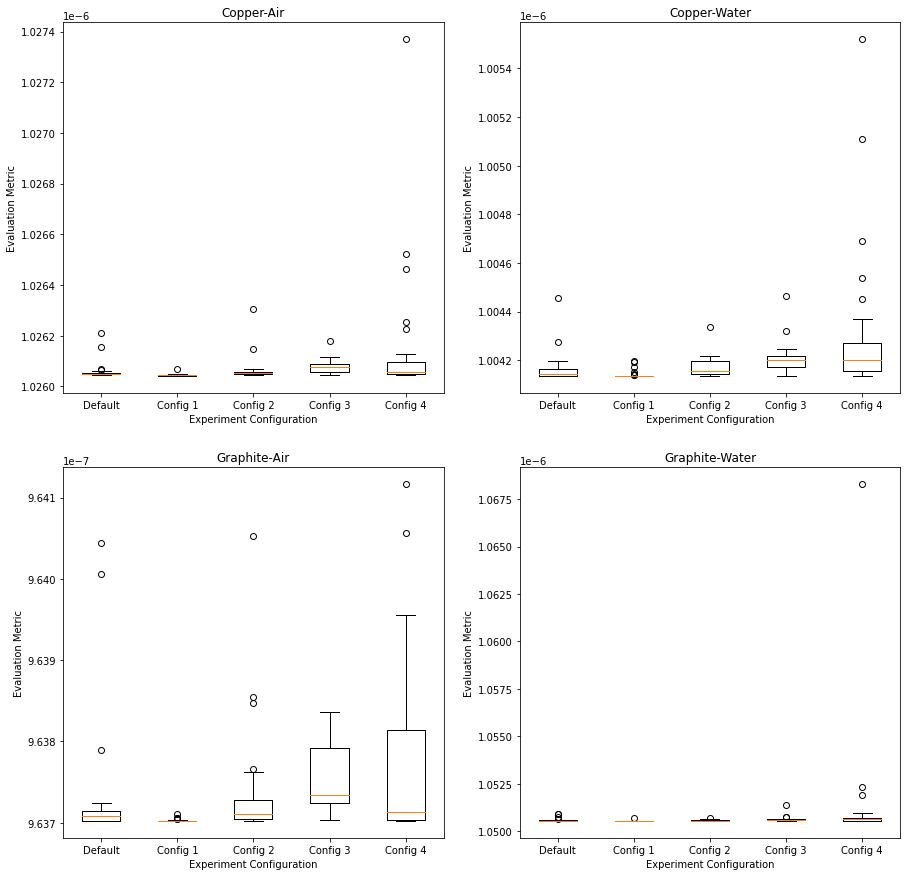

In [6]:
C_A=[perf4[0,:],perf4[1,:],perf4[2,:],perf4[3,:],perf4[4,:]]
C_W=[perf4[5,:],perf4[6,:],perf4[7,:],perf4[8,:],perf4[9,:]]
G_A=[perf4[10,:],perf4[11,:],perf4[12,:],perf4[13,:],perf4[14,:]]
G_W=[perf4[15,:],perf4[16,:],perf4[17,:],perf4[18,:],perf4[19,:]]


#labels = ['Default', '50 Agents', 'Cardinality 2', '50 Iterations', '10 Stagnation']
labels = ['Default', 'Config 1', 'Config 2', 'Config 3', 'Config 4']

fig = plt.figure(figsize =(15, 15))
ax1 =fig.add_subplot(2,2,1)
plt.boxplot(C_A)
plt.title("Copper-Air")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax2 =fig.add_subplot(2,2,2)
plt.boxplot(C_W)
plt.title("Copper-Water")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax3 =fig.add_subplot(2,2,3)
plt.boxplot(G_A)
plt.title("Graphite-Air")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax4 =fig.add_subplot(2,2,4)
plt.boxplot(G_W)
plt.title("Graphite-Water")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
plt.gcf()
plt.savefig('resultsHH2.jpg')
plt.show()


In [7]:
dat = np.array([C_A,C_W,G_A,G_W])
np.save('data_memo_2',dat)

In [8]:
index4=np.empty([1,20])
operators4=np.empty([1,20])
for i in range(0,20):
    y=perf4[i,:]
    x=np.argmin(y)
    index4[0,i]=x
print(index4)

[[23.  8. 20. 15. 14. 25. 10. 14. 20.  3.  7.  0. 14. 22. 15. 13. 25. 24.
  16. 27.]]


In [9]:
ind_best_perf = np.argmin(perf4, axis=1)
best_mhs = [comb4[row, col] for row, col in enumerate(ind_best_perf)]
best_mhs

[[17, 23, 5],
 [4, 2, 16],
 [12, 6],
 [5, 12, 27],
 [12, 4],
 [32, 19, 6],
 [2, 20, 6],
 [12, 4],
 [5, 12, 6],
 [12, 5],
 [5, 9, 12],
 [4, 19, 5],
 [12, 4],
 [1, 5, 12],
 [6, 12],
 [12, 6, 5],
 [6, 16],
 [7, 12],
 [1, 5, 12],
 [12, 5]]

In [10]:
ind_best_perf = np.argmin(perf4, axis=1)
best_mhs = [perf4[row, col] for row, col in enumerate(ind_best_perf)]
best_mhs

[1.0260452033256996e-06,
 1.0260404063336709e-06,
 1.0260453674312521e-06,
 1.0260463784728395e-06,
 1.0260454424706033e-06,
 1.0041345249585162e-06,
 1.004134524569563e-06,
 1.0041346489208512e-06,
 1.0041356615493211e-06,
 1.0041346855271984e-06,
 9.637022116004045e-07,
 9.637021709833021e-07,
 9.637022511554195e-07,
 9.637032017646353e-07,
 9.637022521742962e-07,
 1.0505442296140813e-06,
 1.0505441696477758e-06,
 1.0505447440545939e-06,
 1.0505508494285655e-06,
 1.050544339739786e-06]

In [11]:
ac_tot=[]

for y in range(0,len(comb4)):
    arr_tot= np.array(comb4[y], dtype=object)
    for i in range(0,len(arr_tot)):
        w_tot=np.array(arr_tot[i])
        for z in range(0,len(w_tot)):
            ac_tot.append(w_tot[z])

ac_tot=np.array(ac_tot)
print(ac_tot)

[12  1  7 ... 24 29 26]


In [12]:
sorted=np.sort(ac_tot);
num=[];
num2=[];
frec=[];
ind=[];
count=0;
while len(sorted)>0:
    num.append(str(sorted[0]))
    num2.append(sorted[0])
    cand=sorted[0]
    for i in range(0,len(sorted)):
        if cand == sorted[i]:
            count=count+1
            ind.append(i)
    frec.append(count)
    count=0
    sorted=np.delete(sorted,ind)
    ind=[];
print(num)
print(num2)
print(frec)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
[15, 35, 87, 48, 96, 98, 95, 54, 2, 9, 9, 11, 110, 50, 70, 39, 38, 31, 14, 8, 8, 7, 24, 36, 18, 20, 31, 69, 90, 95, 62, 32, 45]


In [13]:
np.sort(frec)

array([  2,   7,   8,   8,   9,   9,  11,  14,  15,  18,  20,  24,  31,
        31,  32,  35,  36,  38,  39,  45,  48,  50,  54,  62,  69,  70,
        87,  90,  95,  95,  96,  98, 110])

In [14]:
fam=['Random Search','Central Force Dynamic','differential mutation','Firefly Dynamic','genetic crossover','random flight','Local Random Walk','swarm dynamic']
frec2=[0,0,0,0,0,0,0,0]
for i in range(0,len(num2)):
    if num2[i] == 0 or num2[i] == 24:
        frec2[0]= frec2[0] + frec[i]
    elif num2[i] == 1:
        frec2[1]= frec2[1] + frec[i]
    elif num2[i] >= 2 and num2[i] <= 8:
        frec2[2]= frec2[2] + frec[i]
    elif num2[i] == 9:
        frec2[3]= frec2[3] + frec[i]
    elif num2[i] >= 10 and num2[i] <= 21:
        frec2[4]= frec2[4] + frec[i]
    elif num2[i] == 22:
        frec2[5]= frec2[5] + frec[i]
    elif num2[i] == 23:
        frec2[6]= frec2[6] + frec[i]
    elif num2[i] >= 25 and num2[i] <= 32:
        frec2[7]= frec2[7] + frec[i]

print(frec2)
print(fam)

[33, 35, 480, 9, 395, 24, 36, 444]
['Random Search', 'Central Force Dynamic', 'differential mutation', 'Firefly Dynamic', 'genetic crossover', 'random flight', 'Local Random Walk', 'swarm dynamic']


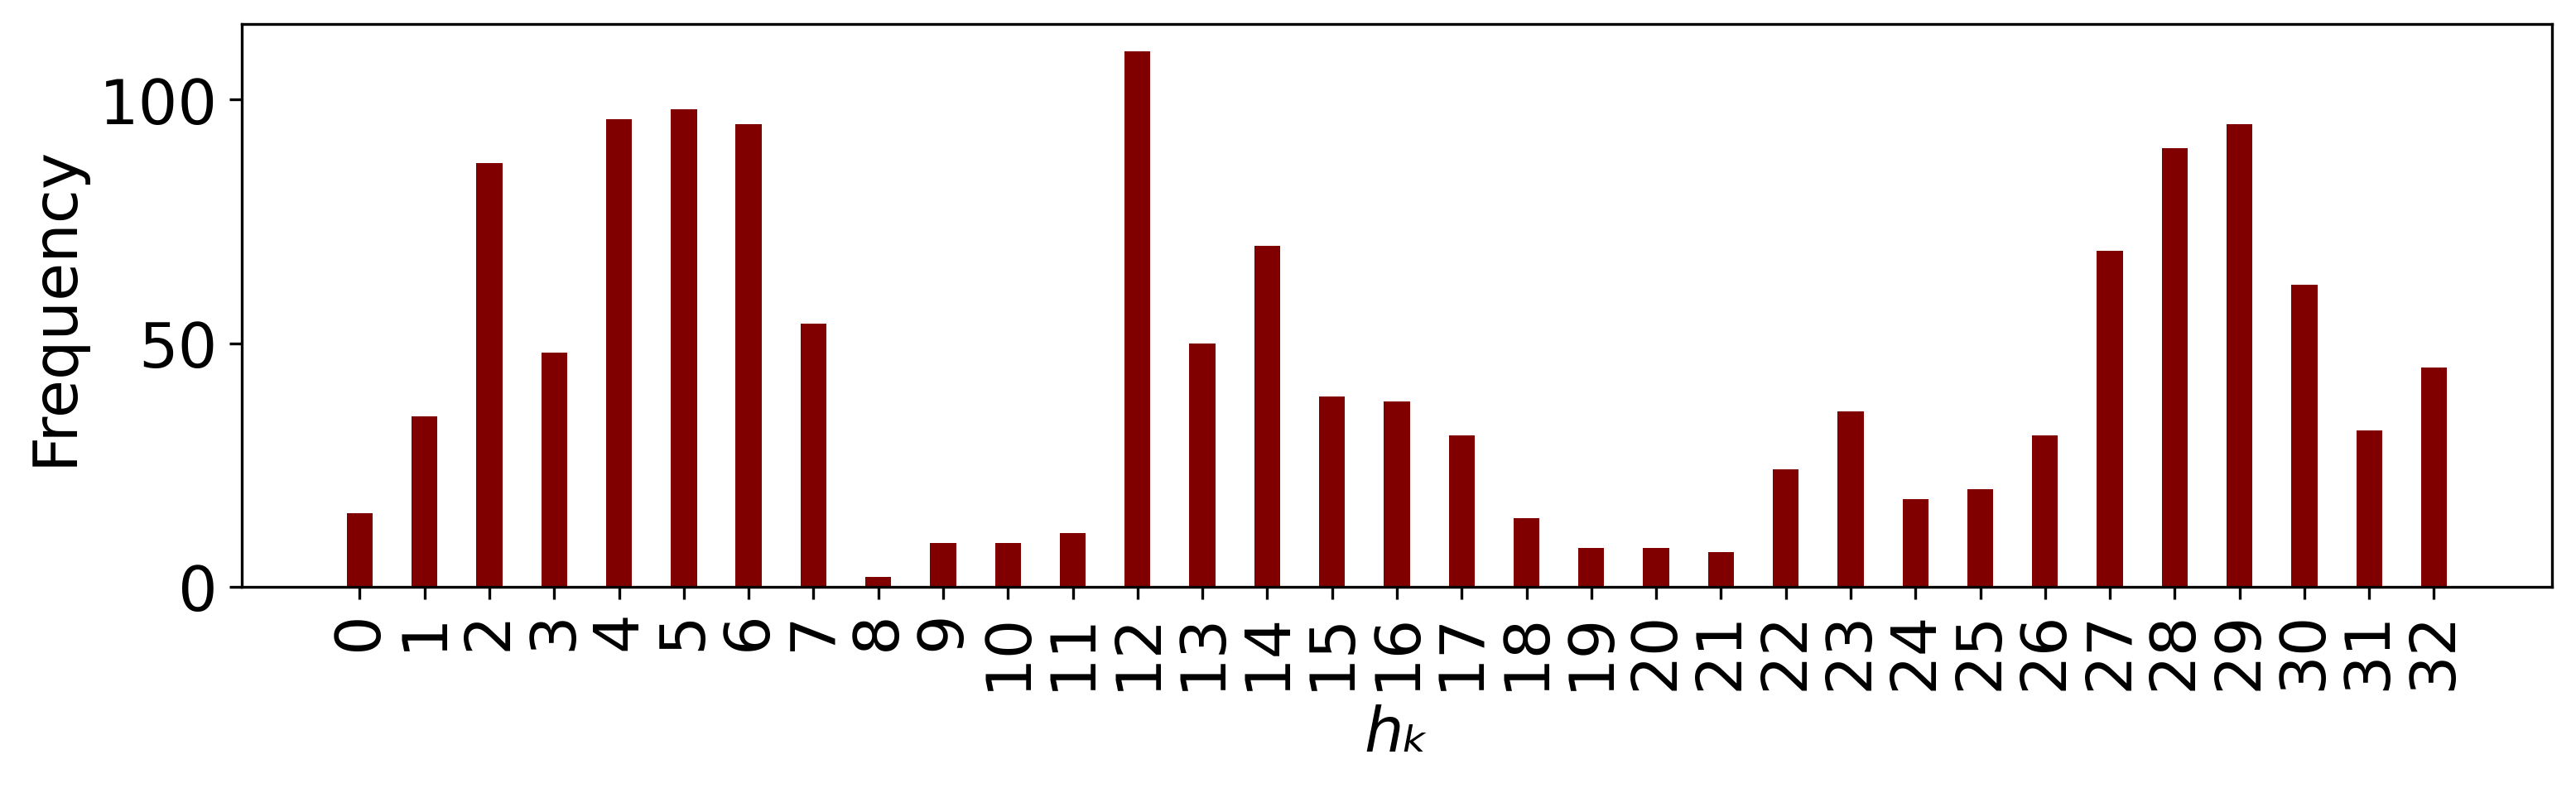

In [69]:
from matplotlib.pyplot import figure
plt.rcParams.update({'font.size': 18})
figure(figsize=(12, 3), dpi=300)
plt.bar(num, frec, color ='maroon',
        width = 0.4)
plt.xticks(range(len(num)), num, rotation='vertical')
plt.xlabel(u'h\u2096', fontstyle='italic')
plt.ylabel("Frequency")
plt.savefig('resultsBG5.jpg',bbox_inches="tight")
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 18})
# Plot the data
fig=plt.bar(num, frec, color ='maroon',
        width = 0.4)

# Adjust the layout to avoid cuts
fig.tight_layout()

# Save the plot to a file
fig.savefig('plot.png', dpi=100)

In [1]:
import glob
import os
import json
import numpy as np
import matplotlib.pyplot as plt

folderO=['data_files/raw/' + filename for filename \
                  in os.listdir('data_files/raw/') if filename.startswith("MC_results3_")]
perf5=np.empty([20,30])
comb5=np.empty([20,30],dtype=object)
file_type = r'\*json'
row=0
for folder in folderO:
    folderI=[folder + '/' + filename for filename \
                  in os.listdir(folder) ]
    column=0
    print(folder)
    for folder2 in folderI:
        #print(folder2)
        list_of_files = glob.glob(folder2 + file_type)
        #print(list_of_files)
        latest_file = max(list_of_files, key=os.path.getmtime)
        #print(latest_file)
        with open(latest_file) as json_file:
            data = json.load(json_file)
            perf5[row,column]=data['performance']
            comb5[row,column]=data['encoded_solution']
        column=column+1
    row=row+1

# Creating plot
#plt.boxplot(vec)

# show plot
#plt.show()
print(perf5)
print(comb5)

data_files/raw/MC_results3_Aluminium_Water
data_files/raw/MC_results3_Aluminium_Water_Ag_50
data_files/raw/MC_results3_Aluminium_Water_Card_2
data_files/raw/MC_results3_Aluminium_Water_It_50
data_files/raw/MC_results3_Aluminium_Water_Stag_10
data_files/raw/MC_results3_Copper_Water
data_files/raw/MC_results3_Copper_Water_Ag_50
data_files/raw/MC_results3_Copper_Water_Card_2
data_files/raw/MC_results3_Copper_Water_It_50
data_files/raw/MC_results3_Copper_Water_Stag_10
data_files/raw/MC_results3_Graphite_Water
data_files/raw/MC_results3_Graphite_Water_Ag_50
data_files/raw/MC_results3_Graphite_Water_Card_2
data_files/raw/MC_results3_Graphite_Water_It_50
data_files/raw/MC_results3_Graphite_Water_Stag_10
data_files/raw/MC_results3_Silicon_Water
data_files/raw/MC_results3_Silicon_Water_Ag_50
data_files/raw/MC_results3_Silicon_Water_Card_2
data_files/raw/MC_results3_Silicon_Water_It_50
data_files/raw/MC_results3_Silicon_Water_Stag_10
[[1.02604554e-06 1.02605127e-06 1.02604521e-06 1.02604977e-06


In [2]:
import statistics
names=["CA","CA_AG","CA_CARD","CA_IT","CA_STAG","CW","CW_AG","CW_CARD","CW_IT","CW_STAG","GA","GA_AG","GA_CARD","GA_IT","GA_STAG","GW","GW_AG","GW_CARD","GW_IT","GW_STAG"]
for i in range(0,20):
    print(names[i])
    average = sum(perf5[i,:])/len(perf5[i,:])
    print("Average of list: ",average)
    sdv=statistics.stdev(perf5[i,:])
    print("Standart Deviation: ", sdv)
    cv= sdv/average
    print("CV: ", cv)
    print("")
    print("")

CA
Average of list:  1.0260473816057472e-06
Standart Deviation:  3.5271373626765832e-12
CV:  3.4375969627802877e-06


CA_AG
Average of list:  1.026041915002624e-06
Standart Deviation:  1.9524648858072366e-12
CV:  1.9029094789000344e-06


CA_CARD
Average of list:  1.026048252475264e-06
Standart Deviation:  3.1108526447623482e-12
CV:  3.0318775333008473e-06


CA_IT
Average of list:  1.0260531504705227e-06
Standart Deviation:  5.0059397452563674e-12
CV:  4.878830831483503e-06


CA_STAG
Average of list:  1.0260496586977272e-06
Standart Deviation:  3.9834016742882954e-12
CV:  3.882269869222577e-06


CW
Average of list:  1.0041388493802444e-06
Standart Deviation:  5.484873137306247e-12
CV:  5.462265642536903e-06


CW_AG
Average of list:  1.0041346399149695e-06
Standart Deviation:  2.1812506704950551e-13
CV:  2.172269119885919e-07


CW_CARD
Average of list:  1.0041440399733542e-06
Standart Deviation:  1.1604579586660047e-11
CV:  1.155668820876334e-05


CW_IT
Average of list:  1.00415739006936

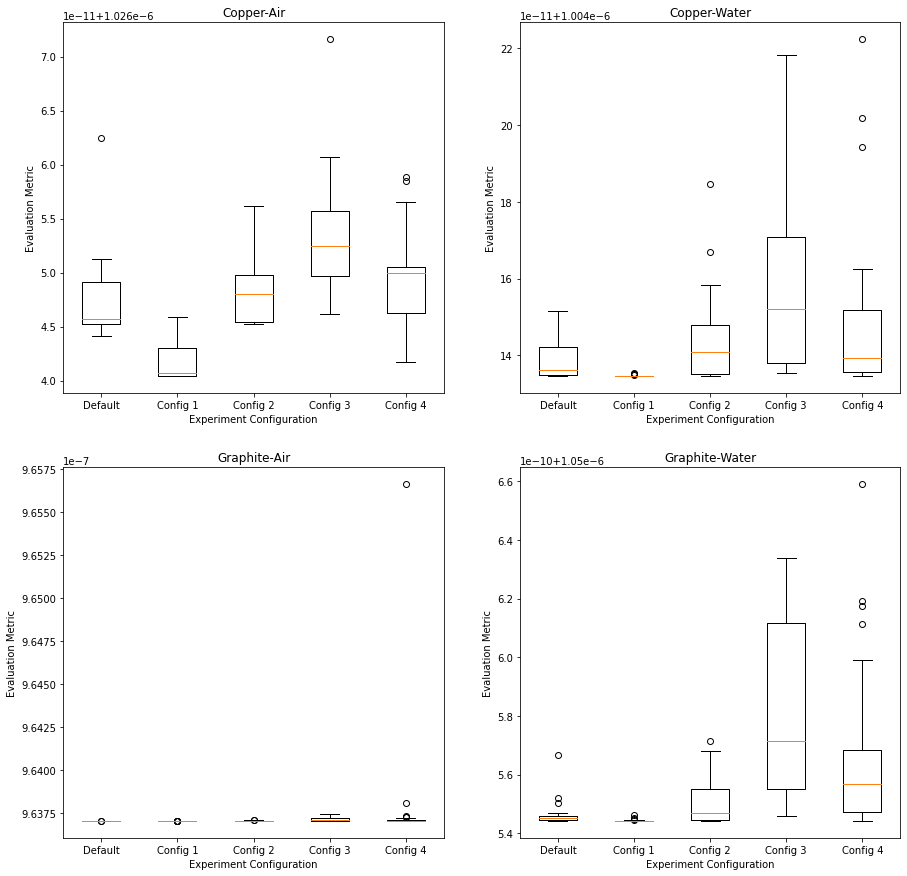

In [3]:
C_A=[perf5[0,:],perf5[1,:],perf5[2,:],perf5[3,:],perf5[4,:]]
C_W=[perf5[5,:],perf5[6,:],perf5[7,:],perf5[8,:],perf5[9,:]]
G_A=[perf5[10,:],perf5[11,:],perf5[12,:],perf5[13,:],perf5[14,:]]
G_W=[perf5[15,:],perf5[16,:],perf5[17,:],perf5[18,:],perf5[19,:]]


#labels = ['Default', '50 Agents', 'Cardinality 2', '50 Iterations', '10 Stagnation']
labels = ['Default', 'Config 1', 'Config 2', 'Config 3', 'Config 4']

fig = plt.figure(figsize =(15, 15))
ax1 =fig.add_subplot(2,2,1)
plt.boxplot(C_A)
plt.title("Copper-Air")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax2 =fig.add_subplot(2,2,2)
plt.boxplot(C_W)
plt.title("Copper-Water")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax3 =fig.add_subplot(2,2,3)
plt.boxplot(G_A)
plt.title("Graphite-Air")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
ax4 =fig.add_subplot(2,2,4)
plt.boxplot(G_W)
plt.title("Graphite-Water")
plt.ylabel("Evaluation Metric")
plt.xlabel("Experiment Configuration")
#plt.yscale("log")
plt.xticks([1, 2, 3, 4, 5], labels)
plt.gcf()
plt.savefig('resultsHH3.jpg')
plt.show()

In [4]:
dat = np.array([C_A,C_W,G_A,G_W])
np.save('data_memo_3',dat)

In [26]:
index5=np.empty([1,20])
operators5=np.empty([1,20])
for i in range(0,20):
    y=perf5[i,:]
    x=np.argmin(y)
    index5[0,i]=x
print(index5)

[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0.]]


In [42]:
ind_best_perf = np.argmin(perf5, axis=1)
best_mhs = [comb5[row, col] for row, col in enumerate(ind_best_perf)]
best_mhs

[[2, 5, 6],
 [6, 0, 3],
 [4, 6],
 [0, 4, 6],
 [6, 12, 5],
 [5, 6, 4],
 [0, 4, 6],
 [6, 3],
 [6, 2, 3],
 [6, 4, 2],
 [6, 4, 3],
 [3, 0, 6],
 [6, 3],
 [6, 2, 3],
 [6, 2, 3],
 [2, 6, 5],
 [6, 0, 4],
 [6, 0, 3],
 [6, 3, 2],
 [5, 3, 6]]

In [43]:
ind_best_perf = np.argmin(perf5, axis=1)
best_mhs = [perf5[row, col] for row, col in enumerate(ind_best_perf)]
best_mhs

[1.026044130186384e-06,
 1.0260404066751844e-06,
 1.0260452708619406e-06,
 1.0260461306571932e-06,
 1.026041695942946e-06,
 1.0041345845472076e-06,
 1.0041345248431098e-06,
 1.0041346364380464e-06,
 1.0041354100360315e-06,
 1.0041345463035698e-06,
 9.637021725775736e-07,
 9.637021710199082e-07,
 9.63702207542153e-07,
 9.63702885796939e-07,
 9.63702172483852e-07,
 1.0505441870366609e-06,
 1.0505441697933196e-06,
 1.050544179465969e-06,
 1.0505457318884373e-06,
 1.0505441941310535e-06]

In [69]:
a= 0.1721225498874615
s= 1.4513993160849943e-05
x=s/a
print(x)

8.43236006574362e-05


In [28]:
ac_tot=[]

for y in range(0,len(comb5)):
    arr_tot= np.array(comb5[y], dtype=object)
    for i in range(0,len(arr_tot)):
        w_tot=np.array(arr_tot[i])
        for z in range(0,len(w_tot)):
            ac_tot.append(w_tot[z])

ac_tot=np.array(ac_tot)
print(ac_tot)

[ 2  8  5 ...  1 12  0]


In [29]:
sorted=np.sort(ac_tot);
num=[];
num2=[];
frec=[];
ind=[];
count=0;
while len(sorted)>0:
    num.append(str(sorted[0]))
    num2.append(sorted[0])
    cand=sorted[0]
    for i in range(0,len(sorted)):
        if cand == sorted[i]:
            count=count+1
            ind.append(i)
    frec.append(count)
    count=0
    sorted=np.delete(sorted,ind)
    ind=[];
print(num)
print(num2)
print(frec)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[76, 46, 118, 92, 76, 108, 197, 183, 93, 66, 95, 94, 71, 92]


In [31]:
sorted=np.sort(ac_tot);
num=[];
num2=[];
frec=[];
ind=[];
count=0;
while len(sorted)>0:
    num.append(str(sorted[0]))
    num2.append(sorted[0])
    cand=sorted[0]
    for i in range(0,len(sorted)):
        if cand == sorted[i]:
            count=count+1
            ind.append(i)
    frec.append(count)
    count=0
    sorted=np.delete(sorted,ind)
    ind=[];
print(num)
print(num2)
print(frec)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[76, 46, 118, 92, 76, 108, 197, 183, 93, 66, 95, 94, 71, 92]


In [32]:
fam=['genetic crossover','random flight','swarm dynamic']
frec2=[0,0,0]
for i in range(0,len(num2)):
    if num2[i] >= 0 and num2[i] <= 2:
        frec2[0]= frec2[0] + frec[i]
    elif num2[i] >= 3 and num2[i] <= 5:
        frec2[1]= frec2[1] + frec[i]
    elif num2[i] >= 6 and num2[i] <= 13:
        frec2[2]= frec2[2] + frec[i]

print(frec2)
print(fam)

[240, 276, 891]
['genetic crossover', 'random flight', 'swarm dynamic']


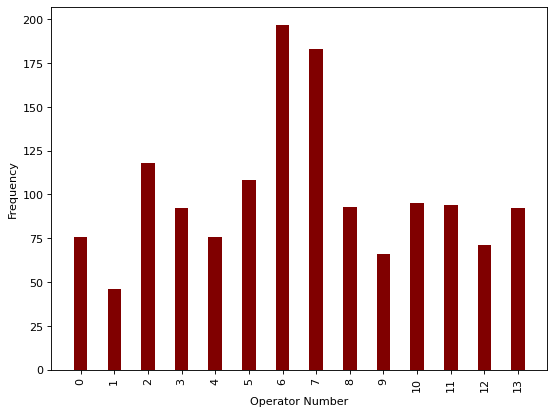

In [33]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(num, frec, color ='maroon',
        width = 0.4)
plt.xticks(range(len(num)), num, rotation='vertical')
plt.xlabel("Operator Number")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG7.jpg')
plt.show()

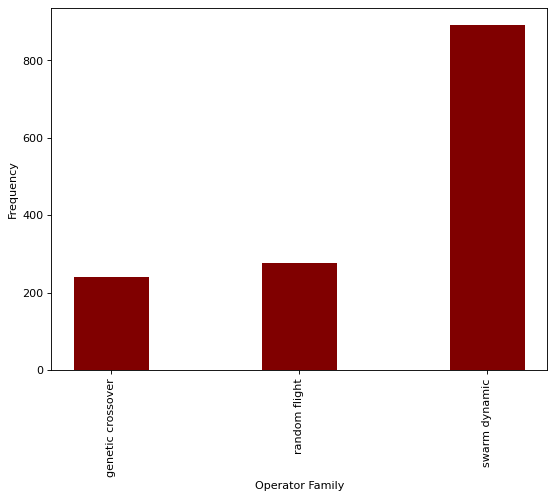

In [34]:
figure(figsize=(8, 6), dpi=80)
plt.bar(fam, frec2, color ='maroon',
        width = 0.4)
plt.xticks(range(len(fam)), fam, rotation='vertical')
plt.xlabel("Operator Family")
plt.ylabel("Frequency")
plt.gcf()
plt.savefig('resultsBG8.jpg',bbox_inches='tight')
plt.show()